In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata


from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess

## Read the phages

Note that the `read_phages()` function filters to <100 contigs by default

In [2]:
df = read_phages()

Please note that this was run with git commit 12a3672 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 1,293,084 prophages from 176,702 genomes

In [3]:
df['fraction pp'] = df['bp prophage']/df['Genome length']
df

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,fraction pp
758,GCA_000003135.1,ASM313v1,2396359.0,114.0,10.0,16.0,2.0,1.0,13.0,48916.0,0.020413
1007,GCA_000271545.1,Pelosinus.strA11_v1.0,5063494.0,134.0,38.0,33.0,6.0,6.0,21.0,218936.0,0.043238
1017,GCA_000271945.1,PgingivalisW50v1.0,2242062.0,104.0,88.0,19.0,0.0,2.0,17.0,0.0,0.000000
1023,GCA_000272065.2,ASM27206v2,4820065.0,595.0,263.0,79.0,1.0,49.0,29.0,15425.0,0.003200
1024,GCA_000272085.2,ASM27208v2,5056409.0,296.0,161.0,69.0,3.0,36.0,30.0,48106.0,0.009514
...,...,...,...,...,...,...,...,...,...,...,...
567389,GCA_904848645.1,LMG_24235,9749118.0,161.0,84.0,48.0,5.0,25.0,18.0,167790.0,0.017211
567394,GCA_905176665.1,D4_OalgB6SA,5465468.0,286.0,71.0,10.0,0.0,10.0,0.0,0.0,0.000000
567395,GCA_905176675.1,G3_OalgB6SA,4272394.0,1048.0,179.0,11.0,0.0,9.0,2.0,0.0,0.000000
567396,GCA_905176695.1,G1_OalgB6SA,3819172.0,8736.0,68.0,2.0,0.0,2.0,0.0,0.0,0.000000


## Compare genome length and prophage bp

Use statistics!

In [6]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 1.156e+05
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        07:11:10   Log-Likelihood:            -2.2280e+06
No. Observations:              176702   AIC:                         4.456e+06
Df Residuals:                  176700   BIC:                         4.456e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.066e+04    586.518    -86.367      0.000   -5.18e+04   -4.95e+04
Genome length     0.0422      0.000    340.011      0.000       0.042       0.042
==============================================================================
Omnibus:                     9242.533   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36257.358
Skew:                           0.060   Prob(JB):                         0.00
Kurtosis:                       5.216   Cond. No.                     1.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.042x + -50655.631
The R-squared is 0.395
The p-value for genome length is 0.000


In [8]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

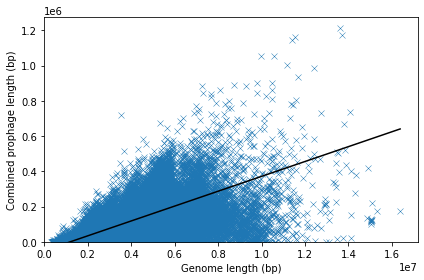

In [9]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [10]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                 8.171e+04
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        07:13:24   Log-Likelihood:            -5.1526e+05
No. Observations:              176702   AIC:                         1.031e+06
Df Residuals:                  176700   BIC:                         1.031e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.5764      0.036    -71.153      0.000      -2.647      -2.505
Genome length   2.19e-06   7.66e-09    285.847      0.000    2.18e-06    2.21e-06
==============================================================================
Omnibus:                    17355.450   Durbin-Watson:                   0.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54192.840
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       5.511   Cond. No.                     1.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 2.190287918057195e-06x + -2.576
The R-squared is 0.316
The p-value for genome length is 0.000


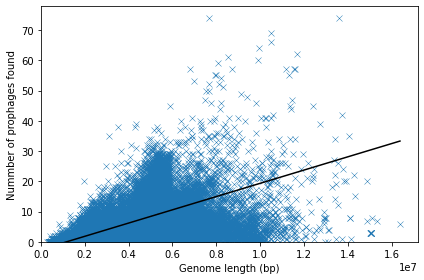

In [12]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 15675.655x + 25267.259
The R-squared is 0.828
The p-value for number of phages kept is 0.000


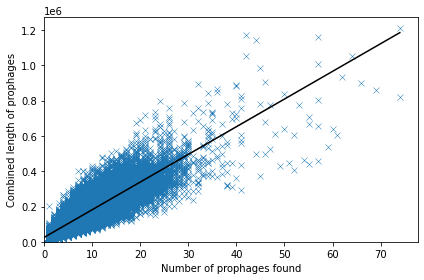

In [13]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [14]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.021x + 45.073
The R-squared is 0.039
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is -0.001x + 7.482
The R-squared is 0.001
The p-value for number of phages kept is 0.000


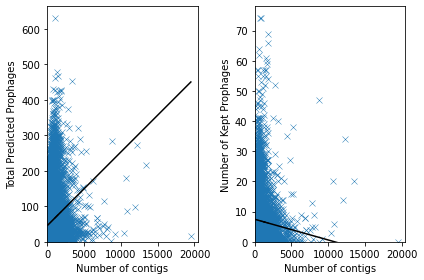

In [15]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

How many contigs are there?

(-10.0, 25.0)

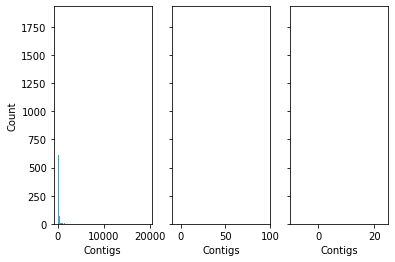

In [16]:
fig, ax =plt.subplots(ncols=3, sharey=True)
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[0])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[1])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[2])
ax[1].set_xlim(-10, 100)
ax[2].set_xlim(-10, 25)

#### Repeating, but only for genomes > 20 contigs

I think the graph is being strongly skewed at the bottom.

In [17]:
ndraft = 20
print(f"There are {sum(df['Contigs'] < ndraft):,} contigs less than {ndraft} contigs")

There are 0 contigs less than 20 contigs



For TOTAL prophages in draft genomes > 20 contigs
The equation is 0.021x +b 45.073 and r**2=0.039

For KEPT prophages
The equation is -0.001x + 7.482 and r**2=0.001


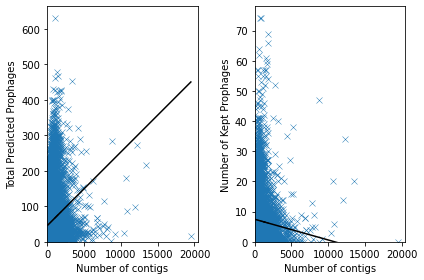

In [18]:
dfdrafts = df[df['Contigs'] > ndraft].copy()
dfdrafts.drop(['contigs vs kept pp', 'contigs vs total pp'], axis=1)
exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Total Predicted Prophages"], exog).fit()
print(f"\nFor TOTAL prophages in draft genomes > {ndraft} contigs")
print(f"The equation is {model.params['Contigs']:.3f}x +b {model.params['const']:.3f} and r**2={model.rsquared:.3f}")

dfdrafts['contigs vs total pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")
dfdrafts['contigs vs kept pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=dfdrafts, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=dfdrafts, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=dfdrafts, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=dfdrafts, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/draftcontigspp.png')

# Filter to sequences with less than 20 contigs

In [19]:
ndraft=20
df = df[df['Contigs'] < ndraft].copy()
df.shape

(66910, 14)

## Some general data about the prophages

In [20]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 3.47 prophages per genome on average, with a mean combined length of 108,010 bp, so 31,128 bp per prophage


In [21]:
print(f"The most prophages is {max(df['Kept'])} in {df.iloc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.iloc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.iloc[df['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


Text(0.5, 0, 'Number of prophages identified')

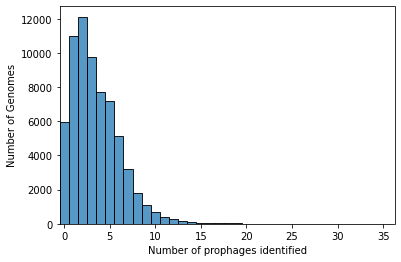

In [22]:
ax = sns.histplot(df['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")

# Filtered Data Set

Lets filter out anything in more than 10 contigs. This should be essentially complete genomes and remove any bias from fragmented genomes

In [23]:
filtermax=10
print(f"Before filtering we have {df.shape[0]:,} genomes")
fdf = df[df['Contigs'] < filtermax].copy()
fdf.reset_index().drop('index', axis=1)
print(f"After filtering for genomes with less than {filtermax} contigs we have {fdf.shape[0]:,} genomes")

Before filtering we have 66,910 genomes
After filtering for genomes with less than 10 contigs we have 26,640 genomes


In [24]:
print(f"After filtering for genomes with less than {filtermax} contigs")
print(f"There are {fdf['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {fdf['bp prophage'].mean():,.0f} bp, so {fdf['bp prophage'].mean()/fdf['Kept'].mean():,.0f} bp per prophage")

After filtering for genomes with less than 10 contigs
There are 3.63 prophages per genome on average, with a mean combined length of 117,874 bp, so 32,500 bp per prophage


In [25]:
print(f"The most prophages is {max(fdf['Kept'])} in {fdf.iloc[fdf['Kept'].argmax()]['Contig']} that has {fdf.iloc[fdf['Kept'].argmax()]['Contigs']} contigs")
print(f"The longest combined amount of prophage DNA is {max(fdf['bp prophage'])} in {fdf.iloc[fdf['bp prophage'].argmax()]['Contig']} that has {fdf.iloc[fdf['bp prophage'].argmax()]['Contigs']} contigs")
print(f"The highest fraction of prophage DNA is {max(fdf['fraction pp']) * 100:.3f}% in {fdf.iloc[fdf['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


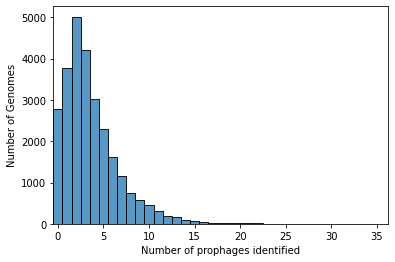

In [26]:
ax = sns.histplot(fdf['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")
fig = ax.get_figure()
fig.savefig('images/pp_hist.png')

### There is no dependency on number of contigs now

When we drop highly fragmented (draft) genomes, we loose the dependency on the number of contigs completely.


For TOTAL prophages
The equation is -0.614x + 28.844
The R-squared is 0.006
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is -0.037x + 3.752
The R-squared is 0.001
The p-value for number of phages kept is 0.000


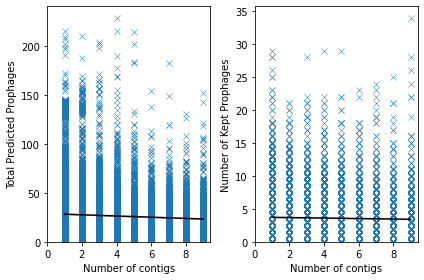

In [27]:
fdf.drop(['contigs vs total pp', 'contigs vs kept pp'], axis=1)

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs total pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs kept pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=fdf, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=fdf, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=fdf, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=fdf, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/filteredcontigspp.png')

# Size distributions

This is mostly for Toni Luque who is really interested in the size distributions of the prophages.